In [38]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [39]:
import numpy as np
import pandas as pd

In [40]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [41]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [42]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [43]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect = True)

In [44]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [45]:
# Save references to each table
measurement = Base.classes.measurement
station = Base.classes.station

In [46]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [47]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

# Calculate the date 1 year ago from the last data point in the database

# Perform a query to retrieve the data and precipitation scores

# Save the query results as a Pandas DataFrame and set the index to the date column

# Sort the dataframe by date

# Use Pandas Plotting with Matplotlib to plot the data

In [48]:
# last day for selected date range
last_date = session.query(measurement.date, measurement.prcp).order_by(measurement.date.desc()).first()[0]

# change the data type into date format
entered_date = dt.datetime.strptime(last_date, "%Y-%m-%d")
entered_date = entered_date.date()

# Calculate the date from 1 year ago from the last data point in the database
one_yr_ago = entered_date - dt.timedelta(days = 365)
one_yr_ago


datetime.date(2016, 8, 23)

In [49]:
# Query to pull the last year data of precipitation
# Query 'measurement_date, measurement_prcp' and save into one_yr_precp

one_yr_precp = session.query(measurement.date, measurement.prcp).filter(measurement.date >= one_yr_ago).\
    filter(measurement.date <= last_date).all()

In [50]:
# Save the query results as a Pandas DataFrame  
# set the index to the date column

df = pd.DataFrame(one_yr_precp, columns=['date', 'prcp'])
df.set_index('date', inplace = True)
df.head(10)

,prcp
date,
2016-08-23,0.00
2016-08-24,0.08
2016-08-25,0.08
2016-08-26,0.00
2016-08-27,0.00
2016-08-28,0.01
2016-08-29,0.00
2016-08-30,0.00
2016-08-31,0.13


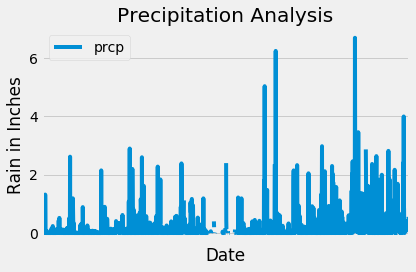

In [51]:
# Plot the dataframe
df.plot()
plt.xticks([])
plt.title("Precipitation Analysis")
plt.ylabel("Rain in Inches")
plt.xlabel("Date")
plt.savefig("Images/precipitation.png")
plt.tight_layout()
plt.show()

## Station Analysis

In [52]:
# Use Pandas to calcualte the summary statistics for the precipitation data
df.describe()

,prcp
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [53]:
# Query showing how many stations are available in this dataset
station_ct = session.query(measurement.station).distinct().count()
print("There are {} stations.".format(station_ct))

There are 9 stations.


In [54]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
active_stations = session.query(measurement.station, func.count(measurement.station)).\
    group_by(measurement.station).\
        order_by(func.count(measurement.station).desc()).all()

active_stations_df = pd.DataFrame(active_stations, columns=["Station", "Data Count"])
active_stations_df.head()

,Station,Data Count
0,USC00519281,2772
1,USC00519397,2724
2,USC00513117,2709
3,USC00519523,2669
4,USC00516128,2612


In [55]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
activest_station = active_stations[0][0]
activest_station

sel = [func.min(measurement.tobs), func.avg(measurement.tobs), func.max(measurement.tobs)]

activest_station_tobs = session.query(*sel).\
    filter(measurement.station==activest_station).all()[0]

print(f"Tempurature Minimum: {activest_station_tobs[0]}")
print(f"Tempurature Average: {activest_station_tobs[1]}")
print(f"Tempurature Maximum: {activest_station_tobs[2]}")

Tempurature Minimum: 54.0
Tempurature Average: 71.66378066378067
Tempurature Maximum: 85.0


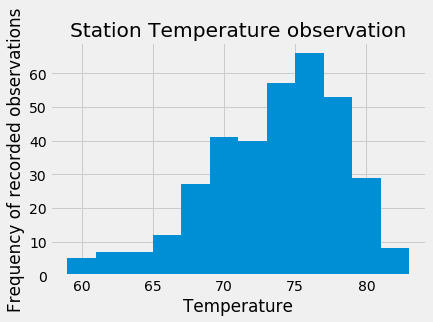

In [56]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

# Only finding the temperature observations within the last 12 months
station_tobs = session.query(measurement.tobs).\
    filter(measurement.date >= one_yr_ago).\
    filter(measurement.date <= last_date).\
    filter(measurement.station == activest_station).all()

tobs_array = np.ravel(station_tobs)
temp_df = pd.Series(tobs_array)

tobs_series.plot.hist(bins=12)
plt.title("Station Temperature observation")
plt.xlabel("Temperature")
plt.ylabel("Frequency of recorded observations")
plt.savefig('Images/station-histogram.png')
plt.show()
